In [1]:
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import os
import matplotlib.patches as patches

In [2]:
tf.compat.v1.enable_eager_execution()
tf.data.experimental.enable_debug_mode()

In [3]:
labels = ["Coleoptera", "Diptera", "Hemiptera", "Hymenoptera", "Lepidoptera", "Odonata"]

def get_label(id): 
    return labels[id]

### Reading the tf record files

In [4]:
tf_records_path = os.path.join(os.getcwd(), "dataset/records")
tf_records = [os.path.join(tf_records_path, path) for path in os.listdir(tf_records_path)]
print(f"found {len(tf_records)} tf records files")

found 68 tf records files


In [5]:
image_feature_description = {
    "image/encoded" : tf.io.FixedLenFeature([], tf.string),
    "image/obj/heights": tf.io.VarLenFeature(tf.float32),
    "image/obj/widths": tf.io.VarLenFeature(tf.float32),
    "image/obj/lefts": tf.io.VarLenFeature(tf.float32),
    "image/obj/tops": tf.io.VarLenFeature(tf.float32),
    "image/obj/class_id": tf.io.VarLenFeature(tf.int64)
}



def parse_function(example_proto): 
    """
        deserialize a raw record
    """
    example =  tf.io.parse_single_example(example_proto, image_feature_description)
    image = tf.image.decode_image(example["image/encoded"], channels=3)

    image = tf.cast(image, dtype=tf.float32) / 255.0
    
    bboxes = tf.stack([
     tf.sparse.to_dense(example["image/obj/heights"]), 
     tf.sparse.to_dense(example["image/obj/widths"]), 
     tf.sparse.to_dense(example["image/obj/lefts"]), # be careful ! inverted with top !
     tf.sparse.to_dense(example["image/obj/tops"]) # be careful ! inverted with left ! 
    ], axis=-1)
    # resizing all images
        
    label = tf.stack(tf.sparse.to_dense(example["image/obj/class_id"]))
    
    return image, bboxes, label
    

### functions to manipulate bounding boxes 

In [6]:
def from_hwlt_to_xyxy(bboxes): 
    """
        convert a bboxs with format whlt to xmin ymin xmax ymax format
        Input: 
            a (n,4) tensor
    """
    print("before converting", bboxes)
    return tf.stack([
        bboxes[:,3], 
        bboxes[:,2], 
        bboxes[:,3] + bboxes[:,1],
        bboxes[:,2] + bboxes[:,0]
    ], axis=-1)

def from_xyxy_to_xywh(bboxes): 
    return tf.stack(
        [(bboxes[:,0] + bboxes[:, 2]) / 2,
        (bboxes[:, 1] + bboxes[:, 3]) / 2,
        bboxes[:, 2] - bboxes[:,0], 
        bboxes[:, 3] - bboxes[:, 1]], 
        axis=-1
    )

def from_xywh_to_xyxy(bboxes): 
    return tf.concat(
        [(bboxes[..., :2] + bboxes[..., 2:]) / 2.0, bboxes[..., 2:] - bboxes[..., :2]],
        axis=-1,
    )

In [7]:
dataset_size = 10000

In [8]:
# opening the raw dataset out of the tf records files
raw_dataset = tf.data.TFRecordDataset(tf_records).take(dataset_size)
dataset = raw_dataset.map(parse_function)

In [9]:
def validate_dataset(filenames, reader_opts=None):
    """
    Attempt to iterate over every record in the supplied iterable of TFRecord filenames
    :param filenames: iterable of filenames to read
    :param reader_opts: (optional) tf.python_io.TFRecordOptions to use when constructing the record iterator
    """
    i = 0
    for fname in filenames:

        record_iterator =  tf.compat.v1.io.tf_record_iterator(path=fname, options=reader_opts)
        try:
            for _ in record_iterator:
                i += 1
        except Exception as e:
            print('error in {} at record {}'.format(fname, i))
            print(e)
            
validate_dataset(tf_records)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [10]:
def parse_bboxes(image, bboxes, label): 
    return image, from_hwlt_to_xyxy(bboxes), label

dataset = dataset.map(parse_bboxes)

before converting Tensor("args_1:0", shape=(None, 4), dtype=float32)


### Visualizing the training data 

In [11]:
def visualize_example(image, bboxes, label):
    
    fig, ax = plt.subplots(figsize=(5,5))
    
    
    boxes = bboxes 
    print(boxes)
    for bbox in boxes: 
        print(bbox)
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0] , bbox[3] - bbox[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    plt.imshow(image) 
    plt.title(get_label(label.numpy()[0]))
    plt.show()
    

before converting tf.Tensor([[ 985.28436 1284.4108   222.41243  320.39697]], shape=(1, 4), dtype=float32)
tf.Tensor([[ 320.39697  222.41243 1604.8077  1207.6968 ]], shape=(1, 4), dtype=float32)
tf.Tensor([ 320.39697  222.41243 1604.8077  1207.6968 ], shape=(4,), dtype=float32)


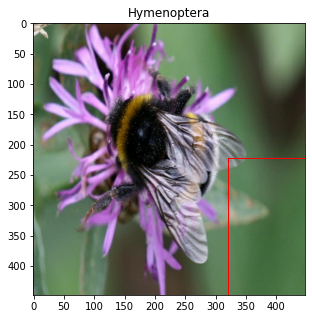

before converting tf.Tensor([[ 73.402275  45.166092 696.70404  999.2998  ]], shape=(1, 4), dtype=float32)
tf.Tensor([[ 999.2998   696.70404 1044.466    770.1063 ]], shape=(1, 4), dtype=float32)
tf.Tensor([ 999.2998   696.70404 1044.466    770.1063 ], shape=(4,), dtype=float32)


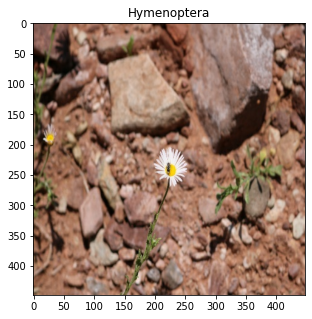

In [12]:
for image, bboxes, label in dataset.take(2):
    visualize_example(image, bboxes, label)

### Model hyperparameters 

In [13]:
width = 448 
height = 448
S = 7
cell_size = (width/ S, height/ S)
batch_size = 32
epochs = 50
nb_boxes = 2

train_split = int(dataset_size * 0.8)
test_split = int(dataset_size * 0.2)

print(train_split, test_split)


8000 2000


In [14]:
def encode_label(image, bboxes, label): 

    """
        given an bboxes and labels
        create a Yolo formatted label of size(SxS, K + 5*nb_boxes) 
        # Important : 
            the width and heights of the bboxes in the target tensor are normalized regarding the IMAGE WIDTH/HEIGHT
            the center coordinates (x,y) are normalized regarding the cell dimensions!
        Argument: 
            bboxes : a (n,4) tensor of xyxy coordinates
            label : a (n,) tensor 
    """
    
    nb_items = tf.shape(bboxes)[0]
    
    boxes = from_xyxy_to_xywh(bboxes)
    one_hot = tf.one_hot(label, depth=len(labels), axis=1, dtype=tf.float32) # (n, 6)
    xy_centers = boxes[:,:2]
    grid_offsets = tf.math.floordiv(xy_centers,64) # (n,2) --> centers
    normalized_centers = xy_centers/cell_size[0] - grid_offsets
    print("not normazlized", boxes[:,2:])
    normalized_wh = boxes[:,2:] / 448
    
    normalized_bbox = tf.concat([normalized_centers, normalized_wh], axis=-1) # (n,4)
    print("normalized_box", normalized_bbox)
    
    confidence = tf.ones((nb_items, 1), dtype=tf.float32) # (n,1)
    
    target = tf.concat([confidence, confidence, normalized_bbox, normalized_bbox, one_hot], axis=-1) # (n, 2+8+6) => # (n,16)
    target = tf.reshape(target, [1, nb_items, nb_boxes * 5 + len(labels)]) # (1, n, 16)
    print("target", target.shape)
    
    
    output_label = tf.zeros((S,S,5*nb_boxes + len(labels)), dtype=tf.float32) # (s,s,16)
    print("output_label", output_label.shape)
    # get centers and computer normalized coordinates
    reversed_grid_offsets = tf.reverse(grid_offsets, axis=[1])
    indices = tf.cast(reversed_grid_offsets,dtype=tf.int32) # (n,2)
    indices = tf.reshape(indices, [1, nb_items, 2]) # (1, n, 2)
    print(target)
    output_label = tf.tensor_scatter_nd_update(output_label, indices, target)
    
    return output_label

In [15]:
dataset = dataset.shuffle(512)
train_dataset = dataset.take(train_split) 
test_dataset = dataset.skip(train_split)

In [16]:
train_dataset = train_dataset.map(encode_label)
test_dataset = test_dataset.map(encode_label)

train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)


not normazlized Tensor("strided_slice_10:0", shape=(None, 2), dtype=float32)
normalized_box Tensor("concat:0", shape=(None, 4), dtype=float32)
target (1, None, 16)
output_label (7, 7, 16)
Tensor("Reshape:0", shape=(1, None, 16), dtype=float32)
not normazlized Tensor("strided_slice_10:0", shape=(None, 2), dtype=float32)
normalized_box Tensor("concat:0", shape=(None, 4), dtype=float32)
target (1, None, 16)
output_label (7, 7, 16)
Tensor("Reshape:0", shape=(1, None, 16), dtype=float32)


In [17]:
for sample in train_dataset.take(1): 
    sample = sample[1][0]
    print(sample)

before converting tf.Tensor([[ 985.28436 1284.4108   222.41243  320.39697]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[ 73.402275  45.166092 696.70404  999.2998  ]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[771.2931  884.1925   93.89655 235.3003 ]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[ 869.2792  1661.2654   255.99461  328.8656 ]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[1270.498   1063.69     214.39655  711.7147 ]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[1413.6781  1662.9183     0.       212.55211]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[623.8161  896.4904  566.9272  421.76245]], shape=(1, 4), dtype=float32)
before converting tf.Tensor(
[[ 319.26437  170.66667  572.32184 1569.1034 ]
 [ 256.       279.54022  860.68964 1104.184  ]
 [ 289.83908  208.91954  634.1149  1320.4597 ]
 [ 244.22989  222.16092  348.68967 1295.4482 ]
 [ 125.05747  400.1839   360.45978  901.1494 ]
 [

before converting tf.Tensor([[574.9655  845.30945 120.01027 157.4969 ]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[ 571.9408   1292.2922     98.837776  152.3818  ]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[ 193.38676  208.89317  698.1156  1247.7133 ]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[ 722.3908 1368.2759  276.5977  427.4023]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[1092.7107  1612.746    281.10632  152.5461 ]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[764.74615  582.62164   61.002872 217.04646 ]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[1198.228    994.88306  217.00192  396.91492]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[1152.8735   1216.0919     25.287355   17.816092]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[526.22125 432.1293  531.8343  826.92523]], shape=(1, 4), dtype=float32)
before converting tf.Tensor(
[[ 266.78928   164.78

before converting tf.Tensor([[424.95953 540.58167 700.4641  951.3108 ]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[1022.14685 1411.2198  1206.819   2197.2158 ]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[1329.3822  1408.6176    71.1791   179.25293]], shape=(1, 4), dtype=float32)
before converting tf.Tensor(
[[ 345.1839   499.2692   354.93488  288.70096]
 [ 234.023    117.01621 1550.4023  1380.8523 ]], shape=(2, 4), dtype=float32)
before converting tf.Tensor(
[[606.89655 648.2759  277.2414  708.2759 ]
 [572.4138  649.65515 488.27585 613.10345]
 [445.51724 805.5172  303.44827 130.34483]], shape=(3, 4), dtype=float32)
before converting tf.Tensor([[1045.7975  1144.6781   216.59546  461.54102]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[674.669   660.2894  213.50049 639.11786]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[616.4598  692.9655  503.17242 704.     ]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[128

before converting tf.Tensor([[1441.3793  859.3506 1189.7931 1684.1503]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[442.47797 441.5379  160.42624 243.34229]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[1.5345287e+03 1.2123219e+03 1.4712644e+00 4.7448276e+02]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[ 645.00934  530.7016   489.04974 1106.5692 ]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[1669.9235  1784.1709   202.25182 1268.9401 ]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[424.90176 378.44244 315.92554 848.18744]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[1134.5403  1192.499    230.88889  556.6509 ]], shape=(1, 4), dtype=float32)
before converting tf.Tensor(
[[ 771.5      786.1523  1569.6034   743.1596 ]
 [ 812.8831  1312.2241   171.44444  208.22137]], shape=(2, 4), dtype=float32)
before converting tf.Tensor([[1218.7135 1296.8932 1106.7487 1843.5176]], shape=(1, 4), dtype=float32)
be

before converting tf.Tensor([[ 997.2285  1542.4363   229.04617  282.65335]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[1451.705  1369.4142  166.159   535.1187]], shape=(1, 4), dtype=float32)
before converting tf.Tensor(
[[ 871.5862  1010.71265  859.31036  681.31036]
 [ 401.0115   253.70116 3134.4368   341.67816]], shape=(2, 4), dtype=float32)
before converting tf.Tensor([[241.28735 769.47125 622.34485 524.50574]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[558.65314 663.6237  285.84256 259.67883]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[431.5661  612.8151  440.37357 700.5606 ]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[1045.8467   1244.8904    112.206215  407.90628 ]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[548.04596 748.0158  283.21838 484.7974 ]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[1851.3009  2268.67     649.28436 1729.1909 ]], shape=(1, 4), dtype=float32)
before convert

before converting tf.Tensor([[1262.7261  1119.5819   220.89464  290.43277]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[ 880.5517  960.      390.6207 1236.4138]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[ 588.4828   466.34482  690.26434 1368.5    ]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[ 436.78162  482.7586  1758.6207   977.0115 ]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[2509.2415 1814.069   480.     1438.3448]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[1593.9773 1050.3763 1010.2523 2379.4238]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[ 569.37933  433.65518 1344.      1838.8966 ]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[1490.333  1593.428   953.0693 1947.1261]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[ 957.8159 1011.0765 1171.0796 2508.0413]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[ 453.89038  753.8415  1328.333   236

before converting tf.Tensor([[1176.       919.4814   167.66911  312.14346]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[ 767.2826  1053.6606   198.1352   300.84415]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[504.82758 699.39655 222.61494 273.44827]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[ 711.98364 1036.7117   286.1973   507.05655]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[389.34387 683.4637  378.37643 480.1833 ]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[1292.023    900.90314  112.03352  389.57422]], shape=(1, 4), dtype=float32)
before converting tf.Tensor(
[[ 297.40134   252.33876   408.77875    27.766148]
 [ 171.80556   165.85646   906.4224    203.10011 ]
 [ 182.46935   196.65837   991.7328    460.17764 ]
 [ 165.88123   164.67177   755.94446  1026.459   ]
 [ 343.6111    239.30717   818.7423    857.04846 ]
 [ 264.2251    225.09091   600.727     359.47906 ]
 [ 280.81323   347.11386   593.6178  

before converting tf.Tensor([[560.9167  541.8145  403.3889  713.43207]], shape=(1, 4), dtype=float32)
before converting tf.Tensor(
[[ 186.36015  221.77873  714.05365  485.11032]
 [ 400.1839   567.20404  800.3678    70.9925 ]
 [ 423.72415  529.9138  1406.5287   542.027  ]], shape=(3, 4), dtype=float32)
before converting tf.Tensor([[783.908   543.1023  156.78162  94.00941]], shape=(1, 4), dtype=float32)
before converting tf.Tensor(
[[ 433.43085  474.57104  710.5901  1031.062  ]
 [1012.27985  967.5034   121.8583   426.54898]], shape=(2, 4), dtype=float32)
before converting tf.Tensor([[419.67392 289.54483 660.2004  858.74756]], shape=(1, 4), dtype=float32)
before converting tf.Tensor(
[[ 538.2709   381.3517   495.35754 1244.3365 ]
 [ 306.57422  474.57104  163.3532   531.06757]], shape=(2, 4), dtype=float32)
before converting tf.Tensor([[841.9193  721.74347 351.1455  586.15173]], shape=(1, 4), dtype=float32)
before converting tf.Tensor([[ 324.7973  470.3338  577.464  1081.9089]], shape=(1, 

not normazlized tf.Tensor([[495.81604 572.3219 ]], shape=(1, 2), dtype=float32)
normalized_box tf.Tensor([[0.06896496 0.5862074  1.1067322  1.2775042 ]], shape=(1, 4), dtype=float32)
target (1, 1, 16)
output_label (7, 7, 16)
tf.Tensor(
[[[1.         1.         0.06896496 0.5862074  1.1067322  1.2775042
   0.06896496 0.5862074  1.1067322  1.2775042  0.         0.
   0.         1.         0.         0.        ]]], shape=(1, 1, 16), dtype=float32)
before converting tf.Tensor([[ 326.37137 2048.       500.3743     0.     ]], shape=(1, 4), dtype=float32)
not normazlized tf.Tensor([[674.2894 457.7088]], shape=(1, 2), dtype=float32)
normalized_box tf.Tensor([[0.5528116  0.65196943 1.5051104  1.0216714 ]], shape=(1, 4), dtype=float32)
target (1, 1, 16)
output_label (7, 7, 16)
tf.Tensor(
[[[1.         1.         0.5528116  0.65196943 1.5051104  1.0216714
   0.5528116  0.65196943 1.5051104  1.0216714  0.         0.
   1.         0.         0.         0.        ]]], shape=(1, 1, 16), dtype=float32

before converting tf.Tensor([[1142.8938 1323.4318    0.      268.3586]], shape=(1, 4), dtype=float32)
not normazlized tf.Tensor([[635.0849 746.5231]], shape=(1, 2), dtype=float32)
normalized_box tf.Tensor([[0.1338234 0.4641266 1.4176003 1.6663462]], shape=(1, 4), dtype=float32)
target (1, 1, 16)
output_label (7, 7, 16)
tf.Tensor(
[[[1.        1.        0.1338234 0.4641266 1.4176003 1.6663462 0.1338234
   0.4641266 1.4176003 1.6663462 0.        0.        0.        1.
   0.        0.       ]]], shape=(1, 1, 16), dtype=float32)
before converting tf.Tensor([[623.8161 775.3563 436.9655 647.3563]], shape=(1, 4), dtype=float32)
not normazlized tf.Tensor([[693.      435.41663]], shape=(1, 2), dtype=float32)
normalized_box tf.Tensor([[0.04036522 0.96809864 1.546875   0.9719121 ]], shape=(1, 4), dtype=float32)
target (1, 1, 16)
output_label (7, 7, 16)
tf.Tensor(
[[[1.         1.         0.04036522 0.96809864 1.546875   0.9719121
   0.04036522 0.96809864 1.546875   0.9719121  0.         0.
   1. 

In [18]:
def conv_block(tensor, filters, kernel_size, stride):
    x = tf.keras.layers.Conv2D(filters=filters,
                               kernel_size=kernel_size,
                               strides=stride,
                               padding='same',
                               use_bias=False,
                               kernel_initializer='he_normal')(tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.1)(x)
    return x


def build_model(H, W, num_classes):
    stride = 64
    grid_shape = [H // cell_size[0], W // cell_size[1]]

    image_input = tf.keras.Input(shape=[H, W, 3], name='image_input')
    x = conv_block(image_input, filters=16, kernel_size=3, stride=1)
    x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
    x = conv_block(x, filters=32, kernel_size=3, stride=1)
    x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
    x = conv_block(x, filters=64, kernel_size=3, stride=1)
    x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
    x = conv_block(x, filters=128, kernel_size=3, stride=1)
    x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
    x = conv_block(x, filters=256, kernel_size=3, stride=1)
    x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
    x = conv_block(x, filters=512, kernel_size=3, stride=1)
    x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
    x = conv_block(x, filters=1024, kernel_size=3, stride=1)
    x = conv_block(x, filters=1024, kernel_size=3, stride=1)
    x = conv_block(x, filters=1024, kernel_size=3, stride=1)
    # Fully convolutional
    predictions = tf.keras.layers.Conv2D(filters=(2 * 5 + num_classes),
                                         kernel_size=1)(x)
    return tf.keras.Model(inputs=[image_input],
                          outputs=[predictions],
                          name='yolo')

In [19]:
def compute_iou(boxes1, boxes2): 
    """
        given two corner coordinates formatted bbox, return the IOU between the gt and the NBOXES other bbox 
        in a cell
    """
    
    corner_boxes1 = from_xywh_to_xyxy(boxes1) 
    corner_boxes2 = from_xywh_to_xyxy(boxes2)
    
    upper_left = tf.maximum(boxes1[...,2:], boxes2[...,2:])
    right_down = tf.minimum(boxes1[...,2:], boxes2[...,2:])
    
    
    intersection_area = (right_down[...,0] - upper_left[...,1]) * (right_down[...,0] - upper_left[...,1])
    intersection_area = tf.maximum(0.0,intersection_area)
    
    union1 = boxes1[...,2] * boxes1[...,3]
    union2 = boxes2[...,2] * boxes2[...,3]
    
    intersection_over_union = intersection_area / (union1 + union2 - intersection_area)
    
    return tf.clip_by_value(intersection_over_union, 0.0, 1.0)

In [20]:

class YoloLoss(tf.keras.losses.Loss): 
    
    def call(self,y_true, y_pred):
        """
            compute the yolo loss 
            Argument: 
                y_true : a (BS,S,S,5*nb_boxes + 6) tensor 
                y_pred : a (BS,S,S,5*nb_boxes + 6) tensor
        """
        
        print("y_true", y_true.shape)
        print("y_pred", y_pred.shape)
        meshgrid = tf.stack([tf.meshgrid(range(S), range(S))], axis=-1) # (S,S,2)
        meshgrid = tf.reshape(meshgrid, [1, S, S, 1, 2]) # (-1, S, S, 1, 2)
        meshgrid = tf.tile(meshgrid, [1, 1, 1, 2, 1]) # (-1, S, S, S, 2, 2)
        meshgrid = tf.cast(meshgrid, tf.float32)

        true_conf = y_true[:,:,:,:1] # (bs, s, s, 1) 
        true_bboxes = y_true[:,:,:,nb_boxes:nb_boxes + 4*nb_boxes] # (bs,s,s,4*nb_boxes)
        resh_true_boxes = tf.reshape(true_bboxes, [-1, S, S, nb_boxes, 4])
        true_classes = y_true[:,:,:,nb_boxes + 4*nb_boxes:]


        pred_conf = y_pred[:,:,:,:nb_boxes] # (bs, s, s, 2) 
        pred_bboxes = y_pred[:,:,:,nb_boxes:nb_boxes + 4*nb_boxes] # (bs,s,s,4*nb_boxes)
        resh_pred_boxes = tf.reshape(pred_bboxes, [-1, S, S, nb_boxes, 4])
        pred_classes = y_pred[:,:,:,nb_boxes + 4*nb_boxes:]
        
        resh_true_boxes = tf.reshape(true_bboxes, [-1, S, S, nb_boxes, 4])
        resh_pred_boxes = tf.reshape(pred_bboxes, [-1, S, S, nb_boxes, 4])

        
        true_bboxes = tf.concat([
            # (-1, S, S, 2, 2) [?,7,7,2,2], [1,7,7,2,4]
            (resh_true_boxes[:,:,:,:,:2] + meshgrid) * cell_size, 
            (resh_true_boxes[:,:,:,:,2:]) * 448
        ],axis=-1) # (-1, S, S, 2, 4)
        
        pred_bboxes = tf.concat([
            # (-1, S, S, 2, 2) [?,7,7,2,2], [1,7,7,2,4]
            (resh_pred_boxes[:,:,:,:,:2] + meshgrid) * cell_size, 
            (resh_pred_boxes[:,:,:,:,2:]) * 448
        ],axis=-1) # (-1, S, S, 2, 4)
        


        # compute the iou 
        iou = compute_iou(resh_pred_boxes, resh_true_boxes) # (bs, s, s, 2) 
        max_iou = tf.reduce_max(iou, axis=-1, keepdims=True) # (bs, s, s, 1) 

        obj = tf.cast(tf.math.equal(iou, max_iou), dtype=tf.float32)  # (bs, s, s, 1) 
        obj = obj * tf.tile(true_conf, [1,1,1,2]) # (bs, s, s, 2) 
            
            
        obj_mask = tf.cast(true_conf, dtype=tf.float32) # (bs, s, s, 1)
            
        no_obj_mask = tf.ones_like(obj) - obj # (bs, s, s, 2) 
        # (bs, s, s, 2, 2) 
        # (bs, s, s, 2, 2) 
        obj_mask_loc = tf.tile(tf.expand_dims(obj_mask, axis=-1), [1,1,1,1,2])
        
        center_loss = tf.reduce_sum(obj_mask_loc * tf.square(resh_true_boxes[:,:,:,:,:2] - resh_pred_boxes[:,:,:,:,:2]))
        wh_loss = tf.reduce_sum(obj_mask_loc * tf.square(tf.sqrt(resh_true_boxes[:,:,:,:,2:]) - resh_pred_boxes[:,:,:,:,2:]))
        conf_obj_loss = tf.reduce_sum(obj * tf.square(iou -  pred_conf)) # iou op : (bs, s, s, 2)  
        conf_noobj_loss = tf.reduce_sum(no_obj_mask * tf.square(pred_conf)) # (bs, s, s, 2)
        cls_loss = tf.reduce_sum(obj_mask * tf.square(true_classes - pred_classes)) # (-1, S, S, len(labels))
        loss =  5 * wh_loss + 5 * center_loss + conf_obj_loss + 0.5*conf_noobj_loss + cls_loss
        return loss
    

In [21]:
yolov1 = build_model(448,448, len(labels))
yolov1.summary()

Model: "yolo"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 448, 448, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 448, 448, 16)      432       
_________________________________________________________________
batch_normalization (BatchNo (None, 448, 448, 16)      64        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 448, 448, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 224, 224, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      4608      
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 32)      128    

In [22]:
class DecodePredictions(tf.keras.layers.Layer):
    
    def __init__(self, **kwargs): 
        super(DecodePredictions, self).__init__(**kwargs)
        
    def call(self, y_pred):
                
        meshgrid = tf.stack([tf.meshgrid(range(S), range(S))], axis=-1) # (S,S,2)
        meshgrid = tf.reshape(meshgrid, [1, S, S, 1, 2]) # (-1, S, S, 1, 2)
        meshgrid = tf.tile(meshgrid, [1, 1, 1, 2, 1]) # (-1, S, S, S, 2, 2)
        meshgrid = tf.cast(meshgrid, tf.float32)
        
        
        pred_conf = y_pred[:,:,:,:nb_boxes] 
        pred_bbox = y_pred[:,:,:,nb_boxes: nb_boxes + nb_boxes*4]
        pred_bbox = tf.reshape(pred_bbox, [-1, S, S, nb_boxes, 4]) 
        pred_cls = y_pred[:,:,:,nb_boxes*4 + nb_boxes:]
        
        denormalized_bbox = tf.concat([
            # (-1, S, S, 2, 2) [?,7,7,2,2], [1,7,7,2,4]
            (pred_bbox[:,:,:,:,:2] + meshgrid) * cell_size, 
            (pred_bbox[:,:,:,:,2:]) * 448
        ],axis=-1) # (-1, S, S, 2, 4)
        
        denormalized_bbox = tf.reshape(denormalized_bbox, [-1, 4])
        
        cls = tf.expand_dims(tf.argmax(pred_cls, axis=-1), axis=-1) 
        cls = tf.tile(cls, [1, 1, 1, 2]) 
        cls = tf.reshape(cls, [-1])
        
        cls_score = tf.reduce_max(pred_cls, axis=-1) 
        cls_score = tf.expand_dims(cls_score, axis=-1)
        cls_score = tf.tile(cls_score, [1,1,1,2])
        
        print("cls_score", cls_score) 
        print("pred_conf", pred_conf)
        
        proba_score = pred_conf * cls_score
        proba_score = tf.reshape(proba_score, [-1])
        
        print("proba_score", proba_score)
        
        denormalized_bbox = from_xywh_to_xyxy(denormalized_bbox)
        
        # takes : 
            # denormalized_bbox : (total_nb_boxes, 4) 
            # cls_score : (total_nb_boxes,)
        indices = tf.image.non_max_suppression(denormalized_bbox, proba_score, 200, 0.5, 0.55)
        
        bbox = tf.gather(denormalized_bbox, indices)
        cls_score = tf.gather(proba_score, indices)
        cls_id = tf.gather(cls, indices)
        
        print("nnms") 
        print("bbox", bbox.shape) 
        print("cls_score", cls_score.shape)
        print("cls_id", cls_id.shape)
        
        return bbox, cls_score, cls_id
        
        
        

In [23]:
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
test_dataset = test_dataset.apply(tf.data.experimental.ignore_errors())

In [24]:

def learning_rate_strategy(strategy, init_lr, decay_rate=0.65): 
    
    def sqrt_scheduling(epoch, lr): 
        return init_lr / (1+decay_rate*epoch)
    
    def step_scheduling(epoch, lr): 
        if epoch <3: 
            return init_lr
        elif epoch < 7: 
            return init_lr * 0.95*tf.exp(epoch)
        elif epoch < 15: 
            return init_lr * 0.85*tf.exp(epoch)
        
    def squared_scheduling(epoch, lr): 
        return init_lr / tf.sqrt(epoch+1)
    
    d = {
        "sqrt": sqrt_scheduling, 
        "step" : step_scheduling, 
        "sqared" : squared_scheduling
    }
    
    return d[strategy]
    

In [25]:
def training_single(strat="sqrt", lr=0.01): 
    loss = YoloLoss()
    unbatched = train_dataset.unbatch().take(1)
    unbatched = unbatched.batch(1)

    scheduler = learning_rate_strategy(strat,lr)

    yolov1 = build_model(448,448, len(labels))
    scheduler = learning_rate_strategy(strat, lr)

    optimizer = tf.keras.optimizers.Adam(lr)
    #log_dir = "logs/fit/" + f"denorm_yolov1_{strat}_0.75_{lr}.h5"
    
    callbacks = [
        tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1),
        #tf.keras.callbacks.ModelCheckpoint(f'denorm_best_yolov1_{strat}_0.75_{lr}_{batch_size}.h5', save_best_only=True, verbose=1),
        #tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1), 
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    ]

    yolov1.compile(
        optimizer=optimizer, 
        loss=loss
    )
    
    
    
    yolov1.fit(
        unbatched.take(1),
        epochs=50, 
        callbacks=callbacks, 
        shuffle=True
    )

In [26]:
# training 
training_single()

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.


ValueError: in user code:

    /home/valentin/.local/lib/python3.8/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /home/valentin/.local/lib/python3.8/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/valentin/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/valentin/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/valentin/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/valentin/.local/lib/python3.8/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /home/valentin/.local/lib/python3.8/site-packages/keras/engine/training.py:787 train_step
        y_pred = self(x, training=True)
    /home/valentin/.local/lib/python3.8/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/valentin/.local/lib/python3.8/site-packages/keras/engine/input_spec.py:266 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer yolo: expected shape=(None, 448, 448, 3), found shape=(None, 7, 7, 16)


In [ ]:
yolov1 = tf.keras.models.load_model(f"denorm_best_yolov1_sqrt_0.75_0.01_{batch_size}.h5", compile=False)

In [ ]:
lr = 0.001
loss = YoloLoss()
strat = "sqrt"
scheduler = learning_rate_strategy(strat, lr)

optimizer = tf.keras.optimizers.Adam(lr)
log_dir = "logs/fit/" + f"phase2_yolov1_{strat}_0.75_{lr}.h5"

callbacks = [
    tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(f'phase2_best_yolov1_{strat}_0.75_{lr}_{batch_size}.h5', save_best_only=True, verbose=1),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1), 
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
]

yolov1.compile(
    optimizer=optimizer, 
    loss=loss
)

yolov1.fit(
    train_dataset,
    epochs=50, 
    callbacks=callbacks, 
    validation_data=test_dataset,
    shuffle=True
)

In [ ]:
#yolov1 = tf.keras.models.load_model(f"phase2_best_yolov1_{strat}_0.75_{lr}_{batch_size}.h5", compile=False)

In [ ]:
# inference 
def yolo_predict(): 
    
    inputs = tf.keras.Input((S,S,16))
    pred = DecodePredictions()(inputs)
    inference_model = tf.keras.Model(inputs=[inputs], outputs=[pred])
    
    return inference_model

In [ ]:
yolo_predicator = yolo_predict()

In [ ]:
def predict_and_visualize(input_image): 
    
    fig, ax = plt.subplots(figsize=(5,5))
    predicted_tensor = yolov1(input_image)
    print(predicted_tensor.shape) 
    
    bbox, cls_score, cls_id = yolo_predicator(predicted_tensor)
    
    plt.imshow(input_image)

In [ ]:
test_sample = list(test_dataset.take(1).as_numpy_iterator())[0]

In [ ]:
test_images = test_sample[0]
test_image = np.expand_dims(test_images[0], axis=0)


In [ ]:
predict_and_visualize(test_image)